In [46]:
from typing import Any, Callable, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Basic GAN

In [2]:
def build_discrim(
    base_filters: int=32,
    drop_rate: float=0.2,
    input_dim: int=28,
    kernel_size: int=3,
    num_blocks: int=2,
    output_activation: str="sigmoid"
) -> Dict[str, Any]:
  """Build discriminator."""

  # Input.
  input = tf.keras.layers.Input(shape=(input_dim, input_dim, 1), name="input")
  h = input

  # Convolutional blocks.
  for i in range(num_blocks):
    h = tf.keras.layers.Conv2D(
        base_filters * (2 ** i),
        kernel_size,
        padding="same",
        name=f"conv{i}"
      )(h)
    width = tf.keras.backend.int_shape(h)[1]
    h = tf.keras.layers.Dropout(rate=drop_rate, name=f"drop{i}")(h)
    if (width % 2 == 0):
      h = tf.keras.layers.MaxPool2D(name=f"pool{i}")(h)
    else:
      h = tf.keras.layers.MaxPool2D(pool_size=1, name=f"pool{i}")(h)
    h = tf.keras.layers.ELU(name=f"elu{i}")(h)

  # Output layer.
  last_conv_shape = tf.keras.backend.int_shape(h)
  h = tf.keras.layers.Flatten(name="flat")(h)
  output = tf.keras.layers.Dense(1, activation=output_activation)(h)

  # Build model.
  model = tf.keras.Model(input, output, name="discriminator")

  # Output.
  return {
    "model": model,
    "input_shape": tf.keras.backend.int_shape(input),
    "last_conv_shape": last_conv_shape[1:],
  }

In [3]:
def build_gen(
    base_filters: int=128,
    input_dim: int=128,
    kernel_size: int=4,
    num_blocks: int=3,
    output_dim: int=28,
) -> Dict[str, Any]:
  """Build generator."""

  # Input.
  input = tf.keras.layers.Input(shape=(input_dim, ), name="input")
  h = tf.keras.layers.Reshape(
      (1, 1,input_dim), name="reshape1")(input)

  # Convolutional blocks.
  for i in range(num_blocks):
    h = tf.keras.layers.Conv2DTranspose(
        base_filters // (2 ** i),
        kernel_size,
        strides=2,
        padding="same",
        name=f"conv{i}",
        use_bias=False
    )(h)
    h = tf.keras.layers.BatchNormalization(name=f"batch{i}")(h)
    h = tf.keras.layers.ELU(name=f"elu{i}")(h)

  last_conv_shape = tf.keras.backend.int_shape(h)

  # Convert to output shape.
  h = tf.keras.layers.Flatten(name="flat")(h)
  target_shape = output_dim * output_dim
  h = tf.keras.layers.Dense(target_shape, activation="tanh")(h)
  output = tf.keras.layers.Reshape(
      (output_dim, output_dim, 1), name="reshape2")(h)

  # Build model.
  model = tf.keras.Model(input, output, name="generator")

  # Output.
  return {
    "model": model,
    "input_shape": tf.keras.backend.int_shape(input),
    "last_conv_shape": last_conv_shape[1:],
  }

In [4]:
class GAN(tf.keras.Model):

  def __init__(
      self, disc: tf.keras.Model, gen: tf.keras.Model, latent_dim: int=128):
    super(GAN, self).__init__()
    self.disc = disc
    self.gen = gen
    self.latent_dim = latent_dim

  def compile(
      self,
      disc_opt: tf.keras.optimizers.Optimizer,
      gen_opt: tf.keras.optimizers.Optimizer,
  ):
    super(GAN, self).compile()
    self.loss_fn = tf.keras.losses.BinaryCrossentropy(name="bce")
    self.disc_opt = disc_opt
    self.gen_opt = gen_opt

    # Loss trackers.
    self.disc_loss = tf.keras.metrics.Mean(name="disc_loss")
    self.gen_loss = tf.keras.metrics.Mean(name="gen_loss")

  @property
  def metrics(self):
    return [
        self.disc_loss,
        self.gen_loss
    ]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_draws = tf.random.normal(shape=(batch_size, self.latent_dim))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      fake_images = self.gen(random_draws, training=True)

      real_probs = self.disc(real_images, training=True)
      fake_probs = self.disc(fake_images, training=True)

      # Label smoothing.
      real_labs = tf.ones_like(real_probs) + \
        0.1 * tf.random.uniform(tf.shape(real_probs))
      fake_labs = tf.zeros_like(fake_probs) + \
        0.1 * tf.random.uniform(tf.shape(fake_probs))

      d_real_loss = self.loss_fn(real_labs, real_probs)
      d_fake_loss = self.loss_fn(fake_labs, fake_probs)
      d_loss = tf.reduce_mean([d_real_loss, d_fake_loss])

      g_loss = self.loss_fn(real_labs, fake_probs)

    # Caculate and apply gradients.
    disc_grads = disc_tape.gradient(d_loss, self.disc.trainable_variables)
    gen_grads = gen_tape.gradient(g_loss, self.gen.trainable_variables)

    self.disc_opt.apply_gradients(zip(disc_grads, self.disc.trainable_variables))
    self.gen_opt.apply_gradients(zip(gen_grads, self.gen.trainable_variables))

    # Update metrics.
    self.disc_loss.update_state(d_loss)
    self.gen_loss.update_state(g_loss)

    return {m.name: m.result() for m in self.metrics}

## Example

### Data

In [5]:
def prepare_mnist_data(
  val_frac: float=0.2,
  seed: int=101,
) -> Dict[str, Any]:

  # Load data.
  (x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()

  # Standardize.
  x_train = (x_train.astype("float32") - 127.5) / 255.0
  x_test  = (x_test.astype("float32") - 127.5) / 255.0

  # Add channel axis.
  x_train = np.expand_dims(x_train, axis=-1)
  x_test = np.expand_dims(x_test, axis=-1)

  # Output.
  return {
    "x_train": x_train,
    "y_train": y_train,
    "x_test": x_test,
    "y_test": y_test,
  }


In [27]:
data = prepare_mnist_data()

11490434/11490434 [==============================] - 0s 0us/step


In [28]:
data["x_train"][0].shape

(28, 28, 1)

### Model

In [25]:
discrim_out = build_discrim()
discrim = discrim_out["model"]
discrim.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv0 (Conv2D)              (None, 28, 28, 32)        320       
                                                                 
 drop0 (Dropout)             (None, 28, 28, 32)        0         
                                                                 
 pool0 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 elu0 (ELU)                  (None, 14, 14, 32)        0         
                                                                 
 conv1 (Conv2D)              (None, 14, 14, 64)        18496     
                                                                 
 drop1 (Dropout)             (None, 14, 14, 64)      

In [26]:
gen_out = build_gen()
generator = gen_out["model"]
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128)]             0         
                                                                 
 reshape1 (Reshape)          (None, 1, 1, 128)         0         
                                                                 
 conv0 (Conv2DTranspose)     (None, 2, 2, 128)         262144    
                                                                 
 batch0 (BatchNormalization  (None, 2, 2, 128)         512       
 )                                                               
                                                                 
 elu0 (ELU)                  (None, 2, 2, 128)         0         
                                                                 
 conv1 (Conv2DTranspose)     (None, 4, 4, 64)          131072    
                                                         

### Training
* Note that no labels are provided.

In [27]:
# Specify model.
disc = build_discrim()["model"]
gen = build_gen()["model"]
gan = GAN(disc, gen)

In [28]:
# Optimizers.
disc_opt = tf.keras.optimizers.AdamW()
gen_opt = tf.keras.optimizers.AdamW()
gan.compile(disc_opt, gen_opt)

In [29]:
# Fit.
history = gan.fit(
  x=data["x_train"],
  batch_size=128,
  epochs=2
)

Epoch 1/2
469/469 [==============================] - 263s 554ms/step - disc_loss: 0.3624 - gen_loss: 2.4219
Epoch 2/2
469/469 [==============================] - 258s 550ms/step - disc_loss: 0.4870 - gen_loss: 1.9573


### Generate

In [32]:
def _gen_img(fit: tf.keras.Model) -> np.ndarray:
  # Extract dimension of latent vector.
  z_dim = fit.gen.layers[0].input_shape[0][1]

  # Draw latent vector.
  draw = tf.random.normal((1, z_dim))

  # Generate image.
  img = fit.gen(draw)
  img = np.squeeze(img, axis=0)

  # Rescale.
  img = (127.5 * img) + 127.5
  return img

In [33]:
def plot_draws(fit: tf.keras.Model, n_draw: int=9):
  fig, axes = plt.subplots(3, 3, figsize=(6, 6))
  axes = axes.flatten()

  for i in range(n_draw):
    img = _gen_img(fit)
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].axis("off")

  plt.tight_layout()
  plt.show()

  return None

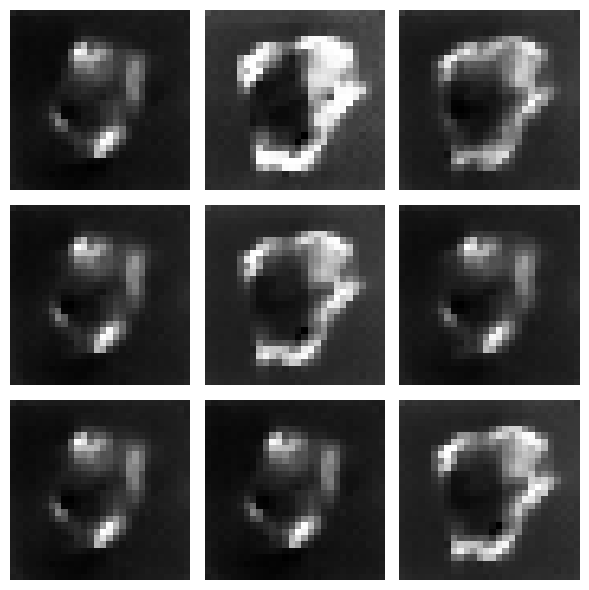

In [32]:
plot_draws(gan)

# WGAN

* Original paper: [Arjovsky 2017](https://arxiv.org/abs/1701.07875)
* [Code example](https://keras.io/examples/generative/wgan_gp/)

In [35]:
class WGAN(tf.keras.Model):

  def __init__(
      self,
      disc: tf.keras.Model,
      gen: tf.keras.Model,
      d_steps: int=5,
      gp_weight: float=10.0,
      latent_dim: int=128,
  ):
    """Wasserstein GAN.

    Args:
      disc: Discriminator model.
      gen: Generator model.
      d_steps: Discriminator steps per generator step.
      gp_weight: Gradient penalty weight.
      latent_dim: Latent dimension from which to generate.
    """
    super(WGAN, self).__init__()
    self.disc = disc
    self.gen = gen
    self.d_steps = d_steps
    self.gp_weight = gp_weight
    self.latent_dim = latent_dim

  def disc_loss_fn(self, real_logits, fake_logits):
    return tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)

  def gen_loss_fn(self, fake_logits):
    return -tf.reduce_mean(fake_logits)

  def compile(
      self,
      disc_opt: tf.keras.optimizers.Optimizer,
      gen_opt: tf.keras.optimizers.Optimizer,
  ):
    super(WGAN, self).compile()
    self.disc_opt = disc_opt
    self.gen_opt = gen_opt

    # Loss trackers.
    self.disc_loss = tf.keras.metrics.Mean(name="disc_loss")
    self.gen_loss = tf.keras.metrics.Mean(name="gen_loss")

  def grad_penalty(self, real_images, fake_images):
    batch_size = tf.shape(real_images)[0]
    alpha = tf.random.uniform(
        shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0)
    interpol = real_images + alpha * (fake_images - real_images)

    with tf.GradientTape() as tape:
      tape.watch(interpol)
      pred = self.disc(interpol, training=True)

    grads = tape.gradient(pred, [interpol])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    return tf.reduce_mean(tf.square(norm - 1.0))

  @property
  def metrics(self):
    return [
        self.disc_loss,
        self.gen_loss
    ]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]

    # Train the descriminator.
    for i in range(self.d_steps):
      random_draws = tf.random.normal(shape=(batch_size, self.latent_dim))

      with tf.GradientTape() as d_tape:
        fake_images = self.gen(random_draws, training=True)
        real_logits = self.disc(real_images, training=True)
        fake_logits = self.disc(fake_images, training=True)

        d_loss = self.disc_loss_fn(real_logits, fake_logits)
        gp = self.grad_penalty(real_images, fake_images)
        d_loss += self.gp_weight * gp

      # Update discriminator.
      disc_grads = d_tape.gradient(d_loss, self.disc.trainable_variables)
      self.disc_opt.apply_gradients(
          zip(disc_grads, self.disc.trainable_variables))

    # Train the generator.
    random_draws = tf.random.normal(shape=(batch_size, self.latent_dim))

    with tf.GradientTape() as g_tape:
      fake_images = self.gen(random_draws, training=True)
      fake_logits = self.disc(fake_images, training=True)
      g_loss = self.gen_loss_fn(fake_logits)

    # Update generator.
    gen_grads = g_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_opt.apply_gradients(zip(gen_grads, self.gen.trainable_variables))

    # Update metrics.
    self.disc_loss.update_state(d_loss)
    self.gen_loss.update_state(g_loss)

    return {m.name: m.result() for m in self.metrics}

## Example

### Data
* See function definition above.

In [36]:
data = prepare_mnist_data()

### Model
* Note the output activation is set to linear such that the discriminator returns logits.

In [37]:
discrim_out = build_discrim(output_activation="linear")
disc = discrim_out["model"]

In [38]:
gen_out = build_gen()
gen = gen_out["model"]

In [39]:
wgan = WGAN(disc, gen)

### Callback

In [56]:
class ImgSaver(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, out_dir="logs/wgan/imgs"):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.out_dir = out_dir
        if not os.path.exists(out_dir):
          os.mkdir(out_dir)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:
          random_draws = tf.random.normal(
              shape=(self.num_img, self.latent_dim))
          gen_imgs = self.model.gen(random_draws)
          gen_imgs = (gen_imgs * 127.5) + 127.5

          for i in range(self.num_img):
              img = gen_imgs[i].numpy()
              img = tf.keras.utils.array_to_img(img)
              out_file = os.path.join(
                  self.out_dir, f"generated_e{epoch}_i{i}.png")
              img.save(out_file)

### Training
* Use GPU

In [57]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
  log_dir="logs/wgan/",
  write_graph=False,
)

In [58]:
# Optimizers.
disc_opt = tf.keras.optimizers.AdamW()
gen_opt = tf.keras.optimizers.AdamW()
wgan.compile(disc_opt, gen_opt)

In [59]:
# Fit.
history = wgan.fit(
  x=data["x_train"],
  batch_size=128,
  epochs=20,
  callbacks=[tensorboard_callback, ImgSaver()]
)

Epoch 1/20
469/469 [==============================] - 35s 59ms/step - disc_loss: -2.7145 - gen_loss: 3.1037
Epoch 2/20
469/469 [==============================] - 28s 59ms/step - disc_loss: -2.4990 - gen_loss: 6.8201
Epoch 3/20
469/469 [==============================] - 27s 58ms/step - disc_loss: -2.2972 - gen_loss: 10.9187
Epoch 4/20
469/469 [==============================] - 28s 59ms/step - disc_loss: -2.0927 - gen_loss: 9.5326
Epoch 5/20
469/469 [==============================] - 28s 59ms/step - disc_loss: -1.9710 - gen_loss: 9.5213
Epoch 6/20
469/469 [==============================] - 27s 59ms/step - disc_loss: -1.8893 - gen_loss: 8.8339
Epoch 7/20
469/469 [==============================] - 28s 59ms/step - disc_loss: -1.8156 - gen_loss: 9.2349
Epoch 8/20
469/469 [==============================] - 28s 59ms/step - disc_loss: -1.7732 - gen_loss: 11.1505
Epoch 9/20
469/469 [==============================] - 28s 59ms/step - disc_loss: -1.7282 - gen_loss: 11.9110
Epoch 10/20
469/469 [====

In [60]:
# %tensorboard --logdir logs/wgan/

### Generate
* See function definitions above.

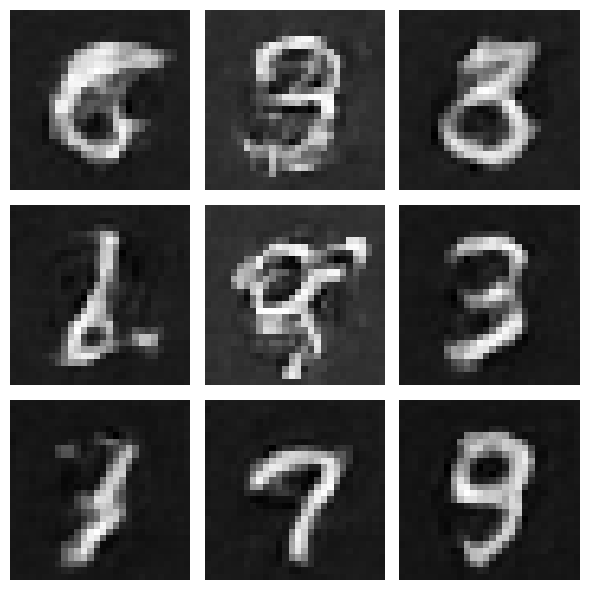

In [61]:
plot_draws(wgan)